In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits
from astropy import wcs
import pandas as pd
import sys
from tqdm import tqdm
from astropy.visualization import ZScaleInterval
from glob import glob
import csv
#import seaborn as sns

from multiprocessing import Pool
import time as tm

from uncertainties import ufloat
from scipy import constants as con
from astropy import constants as ascon
#import pyregion

## Importing data from ExoFOP

In [19]:
all_planets = pd.read_csv('/home/mori/toi1696/data/exofop_tess_tois_new.csv', skiprows=292)
all_planets.columns

/Users/mayuko/miniconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['rowid', 'pl_name', 'hostname', 'pl_letter', 'hd_name', 'hip_name',
       'tic_id', 'gaia_id', 'default_flag', 'sy_snum',
       ...
       'sy_kepmagerr2', 'rowupdate', 'pl_pubdate', 'releasedate', 'pl_nnotes',
       'st_nphot', 'st_nrvc', 'st_nspec', 'pl_nespec', 'pl_ntranspec'],
      dtype='object', length=287)

In [20]:
all_planets=all_planets[all_planets['default_flag']==1]
len(all_planets)

4516

In [21]:
planets=all_planets[all_planets['st_teff']<4000]
len(planets)

330

In [51]:
planets=all_planets[all_planets['st_teff']<4000]

#TSM
planets=planets[planets['pl_rade'].notna()]
planets=planets[planets['pl_rade']<10]

#planets=planets[planets['pl_masse'].notna()]

#planets=planets[planets['pl_eqt'].notna()]  
#planets=planets[planets['pl_ratdor'].notna()]  #ratdor(a/Rs)があるやつはeqtもある
planets=planets[planets['pl_orbsmax'].notna()]  
planets=planets[planets['st_rad'].notna()]

planets=planets[planets['sy_jmag'].notna()]
planets=planets.reset_index()
len(planets)

#ESM

#planets=planets[planets['pl_rade'].notna()]
#planets=planets[planets['pl_eqt'].notna()]
#planets=planets[planets['st_rad'].notna()]
#planets=planets[planets['sy_kmag'].notna()]

151

### mass calculation

In [52]:
#this will take several minutes
mass_list = []
for r, re in zip(planets['pl_rade'], planets['pl_radeerr1']):
    mass = np.median(wolfie.df_from_params2(r, re)['masses']) #Rp, Urp [R_Earth]
    mass_list.append(mass)

In [53]:
planets['mass_calc'] = mass_list

(0.0, 30.0)

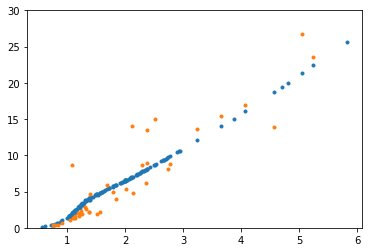

In [54]:
pl.plot(planets['pl_rade'],planets['mass_calc'], '.')
pl.plot(planets['pl_rade'],planets['pl_masse'], '.')
pl.ylim(0, 30)

In [55]:
import math

In [56]:
planets['mass_combine'] = planets['pl_masse']

for i in range(len(planets)):
    if math.isnan(planets['pl_masse'][i])==True:
        planets['mass_combine'][i] =planets['mass_calc'][i]

/Users/mayuko/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Teq Calculation

In [57]:
def Teq(Teff, R_s, semi): #[L_sol]
    R_s_m = R_s * ascon.R_sun
    semi_m = semi * ascon.au
    return Teff * (R_s_m/2./semi_m)**0.5

teff_s = planets['st_teff']
rs_s = planets['st_rad']
a_s = planets['pl_orbsmax']

planets['teq_calc'] = Teq(teff_s, rs_s, a_s)

In [58]:
len(planets)

151

In [61]:
len(planets[planets['pl_eqt'].notna()])

88

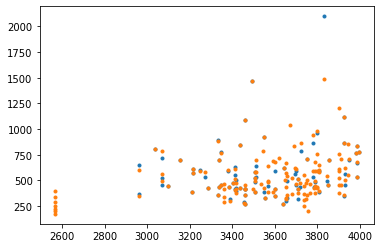

In [62]:
pl.plot(planets['st_teff'], planets['pl_eqt'],'.')
pl.plot(planets['st_teff'], planets['teq_calc'],'.')
#pl.ylim(0,1000)

In [63]:
planets['teq_combine'] = planets['pl_eqt']

for i in range(len(planets)):
    if math.isnan(planets['pl_eqt'][i])==True:
        planets['teq_combine'][i] =planets['teq_calc'][i]

/Users/mayuko/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


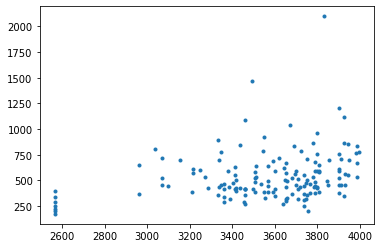

In [64]:
pl.plot(planets['st_teff'], planets['teq_combine'],'.')

# TSM Calculation

In [65]:
Rp = planets['pl_rade']

#Mp = planets['pl_masse']
Mp = planets['mass_combine']

#Teq = planets['pl_eqt']
Teq = planets['teq_combine']

Rs = planets['st_rad']
mJ = planets['sy_jmag']

tsm=[]
for n in range(len(Rp)):
    tsm.append(TSM(Rp[n], Mp[n], Teq[n], Rs[n], mJ[n]))

planets['TSM'] = tsm
planets_TSM = planets

In [66]:
planets_TSM.sort_values('TSM', ascending=False).loc[:,['pl_name','TSM', 'pl_eqt', 'pl_rade']].reset_index()

,index,pl_name,TSM,pl_eqt,pl_rade
0,5,GJ 1214 b,482.123733,596.0,2.742
1,0,AU Mic b,393.336558,593.0,4.070
2,110,L 98-59 d,273.657452,416.0,1.521
3,7,GJ 3470 b,270.204580,594.0,4.570
4,138,TOI-674 b,215.148782,635.0,5.250
...,...,...,...,...,...
146,74,Kepler-186 f,0.272550,NaN,1.170
147,92,Kepler-32 c,0.194939,NaN,2.000
148,127,TOI-1749 b,0.150314,831.0,1.390
149,91,Kepler-32 b,0.042452,NaN,2.200


# ESM Calculation

In [67]:
planets=all_planets[all_planets['st_teff']<4000]
planets=all_planets[all_planets['pl_rade']<4]

#ESM

planets=planets[planets['pl_rade'].notna()]
planets=planets[planets['pl_eqt'].notna()]
planets=planets[planets['st_rad'].notna()]
planets=planets[planets['st_teff'].notna()]
planets=planets[planets['sy_kmag'].notna()]
planets=planets.reset_index()
len(planets)

367

In [68]:
Rp = planets['pl_rade']
Teq = planets['pl_eqt']
Rs = planets['st_rad']
Teff = planets['st_teff']
mK = planets['sy_kmag']

planets['ESM']= ESM(Rp,Teq, Rs, Teff, mK)

planets_ESM = planets

In [69]:
planets_ESM.sort_values('ESM', ascending=False).loc[:,['pl_name','ESM', 'pl_eqt', 'pl_rade']].reset_index()

,index,pl_name,ESM,pl_eqt,pl_rade
0,16,GJ 1214 b,49.082711,596.0,2.742
1,36,HD 219134 b,37.340396,1015.0,1.602
2,161,K2-266 b,34.788284,1515.0,3.300
3,341,TOI-1807 b,31.354327,2100.0,1.849
4,310,LHS 3844 b,28.668561,805.0,1.303
...,...,...,...,...,...
362,272,Kepler-1653 b,0.008603,284.0,2.170
363,296,Kepler-62 e,0.007940,270.0,1.610
364,299,Kepler-69 c,0.005190,299.0,1.710
365,290,Kepler-452 b,0.001819,265.0,1.630


## making figure

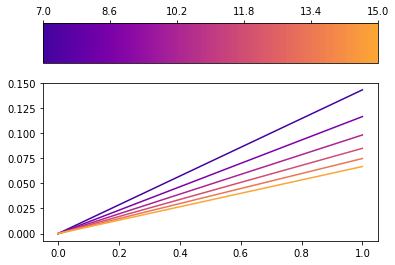

In [70]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patches as patches
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
import matplotlib.colors as mcolors 

gs = gridspec.GridSpec(2, 1, 
         height_ratios=[1, 4] 
         ) 
ax = [plt.subplot(g) for g in gs] 

parameterToColorBy = np.linspace(7, 15, 6, dtype=float) 

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1): 
    if n == -1: 
        n = cmap.N 
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
     'trunc({name},{a:.2f},{b:.2f})'.format(name=cmap.name, a=minval, b=maxval), 
     cmap(np.linspace(minval, maxval, n))) 
    return new_cmap 

minColor = 0.1
maxColor = 0.8
inferno_t = truncate_colormap(plt.get_cmap("plasma"), minColor, maxColor) 

colors = [inferno_t(i) 
      for i in np.linspace(0, 1, parameterToColorBy.shape[0])] 

norm = mpl.colors.Normalize(parameterToColorBy[0], 
          parameterToColorBy[-1]) 

cb = mpl.colorbar.ColorbarBase(ax[0], 
           cmap=inferno_t, 
           norm=norm, 
           ticks=parameterToColorBy, 
           orientation='horizontal') 

ax[0].xaxis.set_ticks_position('top') 

for p, c in zip(parameterToColorBy, colors): 
    ax[1].plot(np.arange(2)/p, c=c) 

In [75]:
df=planets_TSM
df['sy_hmag']

0       4.831
1       4.831
2      12.856
3       9.433
4       8.666
        ...  
146    10.718
147    10.718
148    10.718
149    10.718
150    10.718
Name: sy_hmag, Length: 151, dtype: float64

In [76]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
pl.rcParams['ytick.labelsize'] = 'medium'
pl.rcParams['xtick.labelsize'] ='medium'
fontsize=20

In [77]:
df

,index,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_id,default_flag,...,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,mass_calc,mass_combine,teq_calc,teq_combine,TSM
0,138,139,AU Mic b,AU Mic,b,HD 197481,HIP 102409,TIC 441420236,Gaia DR2 6794047652729201024,1,...,1,0,1,0,0,16.181961,17.000000,608.395224,593.000000,393.336558
1,140,141,AU Mic c,AU Mic,c,HD 197481,HIP 102409,TIC 441420236,Gaia DR2 6794047652729201024,1,...,1,0,1,0,0,12.065973,13.600000,465.663281,454.000000,211.368088
2,302,303,EPIC 201170410.02,EPIC 201170410,b,NaN,NaN,TIC 38116202,Gaia DR2 3786541956697428224,1,...,0,0,0,0,0,1.446691,1.446691,498.258171,498.258171,1.943374
3,390,391,G 9-40 b,G 9-40,b,NaN,NaN,TIC 203214081,Gaia DR2 684992690384102528,1,...,0,0,0,0,0,6.624521,6.624521,458.109428,456.000000,72.968027
4,398,399,GJ 1132 b,GJ 1132,b,NaN,NaN,TIC 101955023,Gaia DR2 5413438219396893568,1,...,0,0,0,0,117,2.362047,1.660000,584.177711,529.000000,28.047743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,29034,29035,TRAPPIST-1 d,TRAPPIST-1,d,NaN,NaN,TIC 278892590,Gaia DR2 2635476908753563008,1,...,0,0,0,0,0,0.530663,0.388000,287.223827,287.223827,25.618783
147,29036,29037,TRAPPIST-1 e,TRAPPIST-1,e,NaN,NaN,TIC 278892590,Gaia DR2 2635476908753563008,1,...,0,0,0,0,0,1.012017,0.692000,250.621103,250.621103,19.946474
148,29039,29040,TRAPPIST-1 f,TRAPPIST-1,f,NaN,NaN,TIC 278892590,Gaia DR2 2635476908753563008,1,...,0,0,0,0,0,1.769867,1.039000,218.477450,218.477450,16.971923
149,29043,29044,TRAPPIST-1 g,TRAPPIST-1,g,NaN,NaN,TIC 278892590,Gaia DR2 2635476908753563008,1,...,0,0,0,0,13,2.432698,1.321000,198.069905,198.069905,15.261197


In [78]:
Rp_plot = list(df['pl_rade'])
Rp_plot.append(Rp_tg)

Per_plot = list(df['pl_orbper'])
Per_plot.append(Per_tg)

eq_plot = list(df['pl_eqt'])
eq_plot.append(Teq_tg)
#eq_plot

tsm_plot=list(df['TSM'])
tsm_plot.append(TSM_tg)

hmag_plot = list(df['sy_hmag'])
hmag_plot.append(11.604)

In [79]:
TSM_tg

82.41421663218406

In [80]:
all_planets[all_planets['hostname']=='TRAPPIST-1']['pl_orbper']

29023     1.510826
29027     2.421937
29034     4.049219
29036     6.101013
29039     9.207540
29043    12.352446
29044    18.772866
Name: pl_orbper, dtype: float64

No handles with labels found to put in legend.


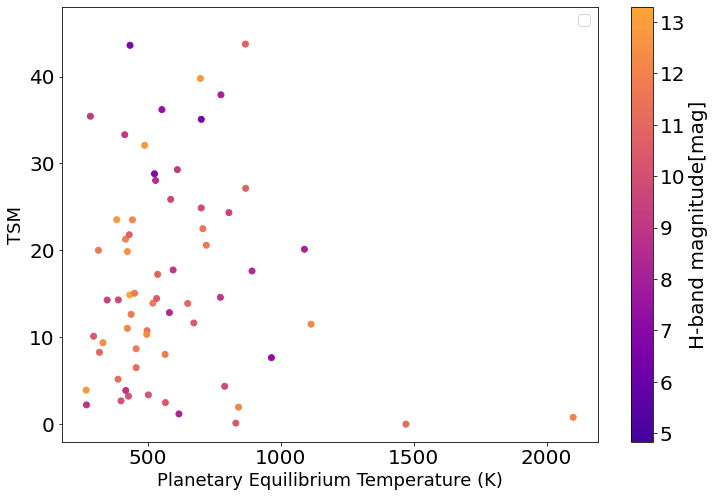

In [81]:
f = pl.figure(figsize=(12,8))

#df = planets_TSM[planets_TSM['sy_hmag']<11]
df = planets_TSM

sc =pl.scatter(eq_plot,tsm_plot,  alpha=1, c=hmag_plot, cmap=inferno_t)

#sc =pl.scatter(df['pl_eqt'],df['TSM'],  alpha=1, c=df['sy_hmag'], cmap=inferno_t)
#sc =pl.scatter(df['pl_eqt'],df['TSM'],  s=df['pl_trandep']*100, alpha=1, c=df['sy_hmag'], cmap=inferno_t, label=': Depth=1%')
pl.colorbar(sc, label='H-band magnitude[mag]')
pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)

plt.scatter(Teq_tg, TSM_tg,  facecolor='None', edgecolors='deepskyblue', s=180)

pl.xlabel('Planetary Equilibrium Temperature (K)',fontsize=18)
pl.ylabel(r'TSM', fontsize=18)

#pl.legend()
#pl.text(210,0.6, 'TRAPPIST-1 Planets',fontsize=18, c='orange')
#pl.xlim(200, 1200)
pl.ylim(-2, 48)
f.savefig('TSM_scatter.png')

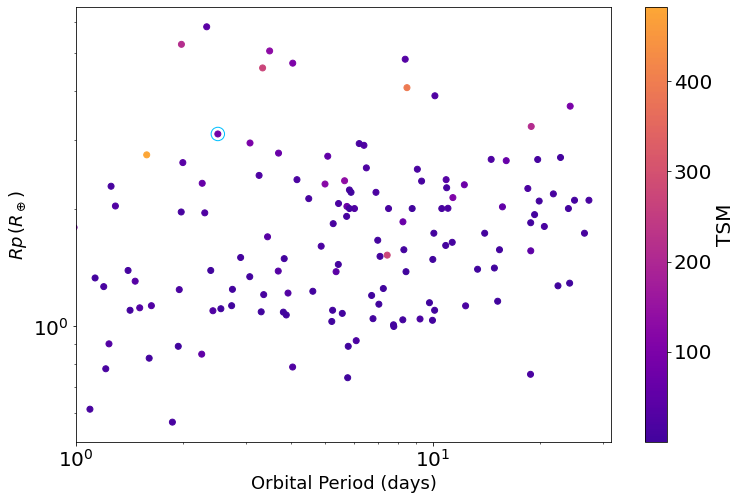

In [82]:
f = pl.figure(figsize=(12,8))

#df = planets_TSM[planets_TSM['sy_hmag']<11]
df = planets_TSM

sc =pl.scatter(Per_plot, Rp_plot,  alpha=1, c=tsm_plot, cmap=inferno_t)

pl.colorbar(sc, label='TSM')
#pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)


plt.scatter(Per_tg, Rp_tg,  facecolor='None', edgecolors='deepskyblue', s=180)

pl.xlabel('Orbital Period (days)',fontsize=18)
pl.ylabel(r'$Rp\,(R_\oplus)$', fontsize=18)

pl.loglog()
pl.xlim(1,10**1.5)
#pl.ylim(1, 10**0.7)

f.savefig('TSM_scatter.png')

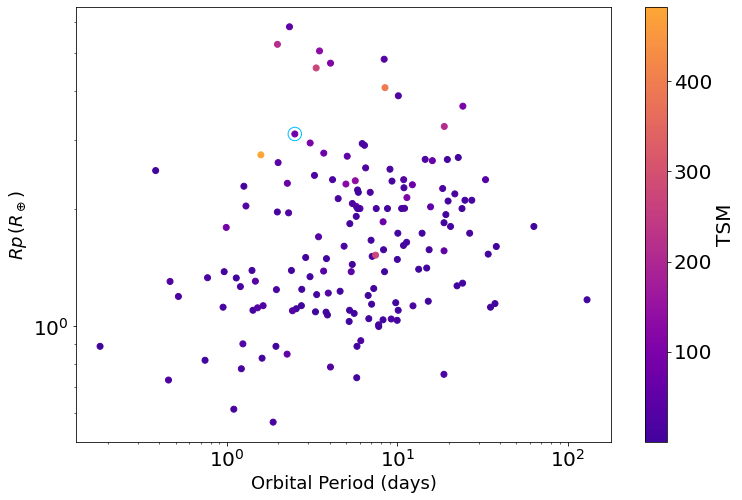

In [85]:
f = pl.figure(figsize=(12,8))

df = planets_TSM[planets_TSM['sy_hmag']<11]
#df = planets_TSM

sc =pl.scatter(Per_plot, Rp_plot,  alpha=1, c=tsm_plot, cmap=inferno_t)

pl.colorbar(sc, label='TSM')
#pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)


plt.scatter(Per_tg, Rp_tg,  facecolor='None', edgecolors='deepskyblue', s=180)

pl.xlabel('Orbital Period (days)',fontsize=18)
pl.ylabel(r'$Rp\,(R_\oplus)$', fontsize=18)

pl.loglog()
#pl.xlim(1,10**1.5)
#pl.ylim(1, 10**0.7)

f.savefig('TSM_scatter.png')

In [98]:
map x: x*10 (hmag_plot)

SyntaxError: invalid syntax (<ipython-input-98-732c3879912e>, line 1)

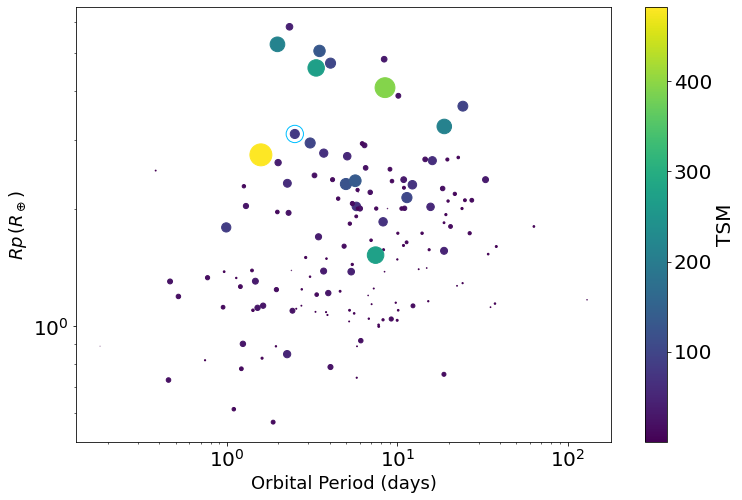

In [100]:
f = pl.figure(figsize=(12,8))

df = planets_TSM[planets_TSM['sy_hmag']<11]
#df = planets_TSM

sc =pl.scatter(Per_plot, Rp_plot,  alpha=1, c=tsm_plot, s=tsm_plot)

pl.colorbar(sc, label='TSM')
#pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)


plt.scatter(Per_tg, Rp_tg,  facecolor='None', edgecolors='deepskyblue', s=300)

pl.xlabel('Orbital Period (days)',fontsize=18)
pl.ylabel(r'$Rp\,(R_\oplus)$', fontsize=18)

pl.loglog()
#pl.xlim(1,10**1.5)
#pl.ylim(1, 10**0.7)

f.savefig('TSM_scatter.png')

No handles with labels found to put in legend.


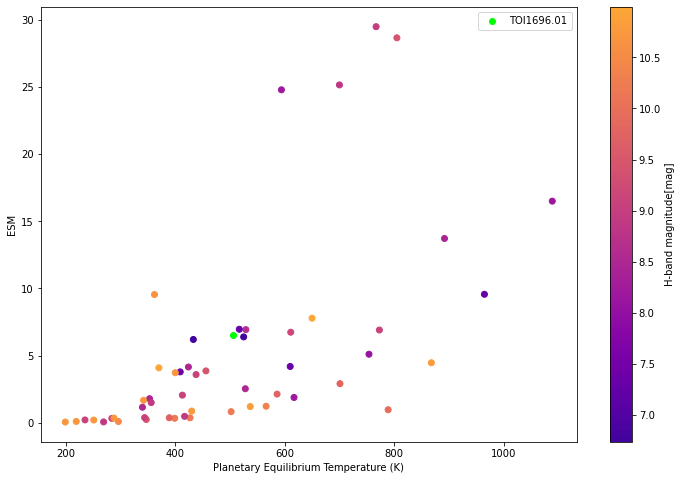

In [347]:
f = pl.figure(figsize=(12,8))

df = planets_ESM[planets_ESM['sy_hmag']<11]

#sc =pl.scatter(df['pl_eqt'],df['ESM'],  s=df['pl_trandep']*100, alpha=1, c=df['sy_hmag'], cmap=inferno_t, label=': Depth=1%')
sc =pl.scatter(df['pl_eqt'],df['ESM'],  alpha=1, c=df['sy_hmag'], cmap=inferno_t)
pl.colorbar(sc, label='H-band magnitude[mag]')
pl.legend(loc="upper right", markerscale=1., scatterpoints=1, fontsize=15)

#pl.scatter(Teq_tg, ESM_tg,  (dep_tg*100), facecolor='skyblue', edgecolors='red', lw=2,  label='TOI1696.01')
pl.scatter(Teq_tg, ESM_tg, facecolor='lime', label='TOI1696.01')

pl.xlabel('Planetary Equilibrium Temperature (K)')
pl.ylabel(r'ESM')

#pl.text(210,0.6, 'TRAPPIST-1 Planets',fontsize=18, c='orange')

#pl.xlim(820, 100)
pl.legend()

#f.savefig('S21A_scatter2.png')

samples: planets with Teff < 4000K & H < 11mag with all information needed